# SimNet Training for Balancing Robot

This notebook trains a SimNet model using both physics simulation data and real-world data.

In [1]:
import sys
sys.path.append('..')

import torch
import numpy as np
from pathlib import Path
import json
import yaml
from matplotlib import pyplot as plt

from src.balancing_robot.models import SimNet
from src.balancing_robot.environment import BalancerEnv
from src.balancing_robot.training import SimNetTrainer
from src.balancing_robot.visualization import plot_predictions_comparison

## Load Configuration

In [2]:
# Load configurations
with open('../configs/simnet_config.yaml', 'r') as f:
    simnet_config = yaml.safe_load(f)

with open('../configs/env_config.yaml', 'r') as f:
    env_config = yaml.safe_load(f)

# Create directories
log_dir = Path('logs/simnet_training')
log_dir.mkdir(parents=True, exist_ok=True)

## Initialize Models and Environment

In [3]:
# Set random seeds
torch.manual_seed(simnet_config['data_collection']['random_seed'])
np.random.seed(simnet_config['data_collection']['random_seed'])

# Create environment for physics data
env = BalancerEnv(config_path='../configs/env_config.yaml')

# Initialize trainer with config
trainer = SimNetTrainer(
    env=env,
    config_path='../configs/simnet_config.yaml'
)

c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


## Collect and Process Physics Data

In [4]:
# Collect physics simulation data
train_data, val_data = trainer.collect_physics_data()

print(f"Collected {len(train_data['states'])} training samples")
print(f"Collected {len(val_data['states'])} validation samples")

Collected 800000 training samples
Collected 200000 validation samples


## Train on Physics Data

In [5]:
# Train on physics data
physics_history = trainer.train(
    train_data=train_data,
    val_data=val_data,
    is_finetuning=False,
    log_dir=log_dir / 'physics'
)

Epoch 1/100 - Train Loss: 618132.790153 - Val Loss: 576933.185657
Epoch 2/100 - Train Loss: 513583.249580 - Val Loss: 448471.159295
Epoch 3/100 - Train Loss: 382350.587068 - Val Loss: 321333.181330
Epoch 4/100 - Train Loss: 267647.207937 - Val Loss: 219570.417027
Epoch 5/100 - Train Loss: 179278.721536 - Val Loss: 145119.728365
Epoch 6/100 - Train Loss: 115621.095708 - Val Loss: 91302.968835
Epoch 7/100 - Train Loss: 71950.727730 - Val Loss: 56050.083456
Epoch 8/100 - Train Loss: 43674.913281 - Val Loss: 32828.768446
Epoch 9/100 - Train Loss: 26329.145983 - Val Loss: 20364.216816
Epoch 10/100 - Train Loss: 16443.729363 - Val Loss: 11862.032003
Epoch 11/100 - Train Loss: 11051.581937 - Val Loss: 9014.736873
Epoch 12/100 - Train Loss: 7891.584932 - Val Loss: 6717.467554
Epoch 13/100 - Train Loss: 5798.655338 - Val Loss: 3820.996980
Epoch 14/100 - Train Loss: 5250.260867 - Val Loss: 4027.237379
Epoch 15/100 - Train Loss: 4199.338823 - Val Loss: 5373.817134
Epoch 16/100 - Train Loss: 4066.

## Load and Process Real-World Data

In [6]:
# # Load real-world log data
# log_file = Path('../data/robot_logs.json')
# with open(log_file, 'r') as f:
#     log_data = json.load(f)

# # Process real data
# real_train_data, real_val_data = trainer.process_real_data(log_data['episodes'])

# print(f"Processed {len(real_train_data['states'])} real training samples")
# print(f"Processed {len(real_val_data['states'])} real validation samples")

## Fine-tune on Real Data

In [7]:
# # Fine-tune on real data
# real_history = trainer.train(
#     train_data=real_train_data,
#     val_data=real_val_data,
#     is_finetuning=True,
#     log_dir=log_dir / 'real'
# )

## Analyze Predictions

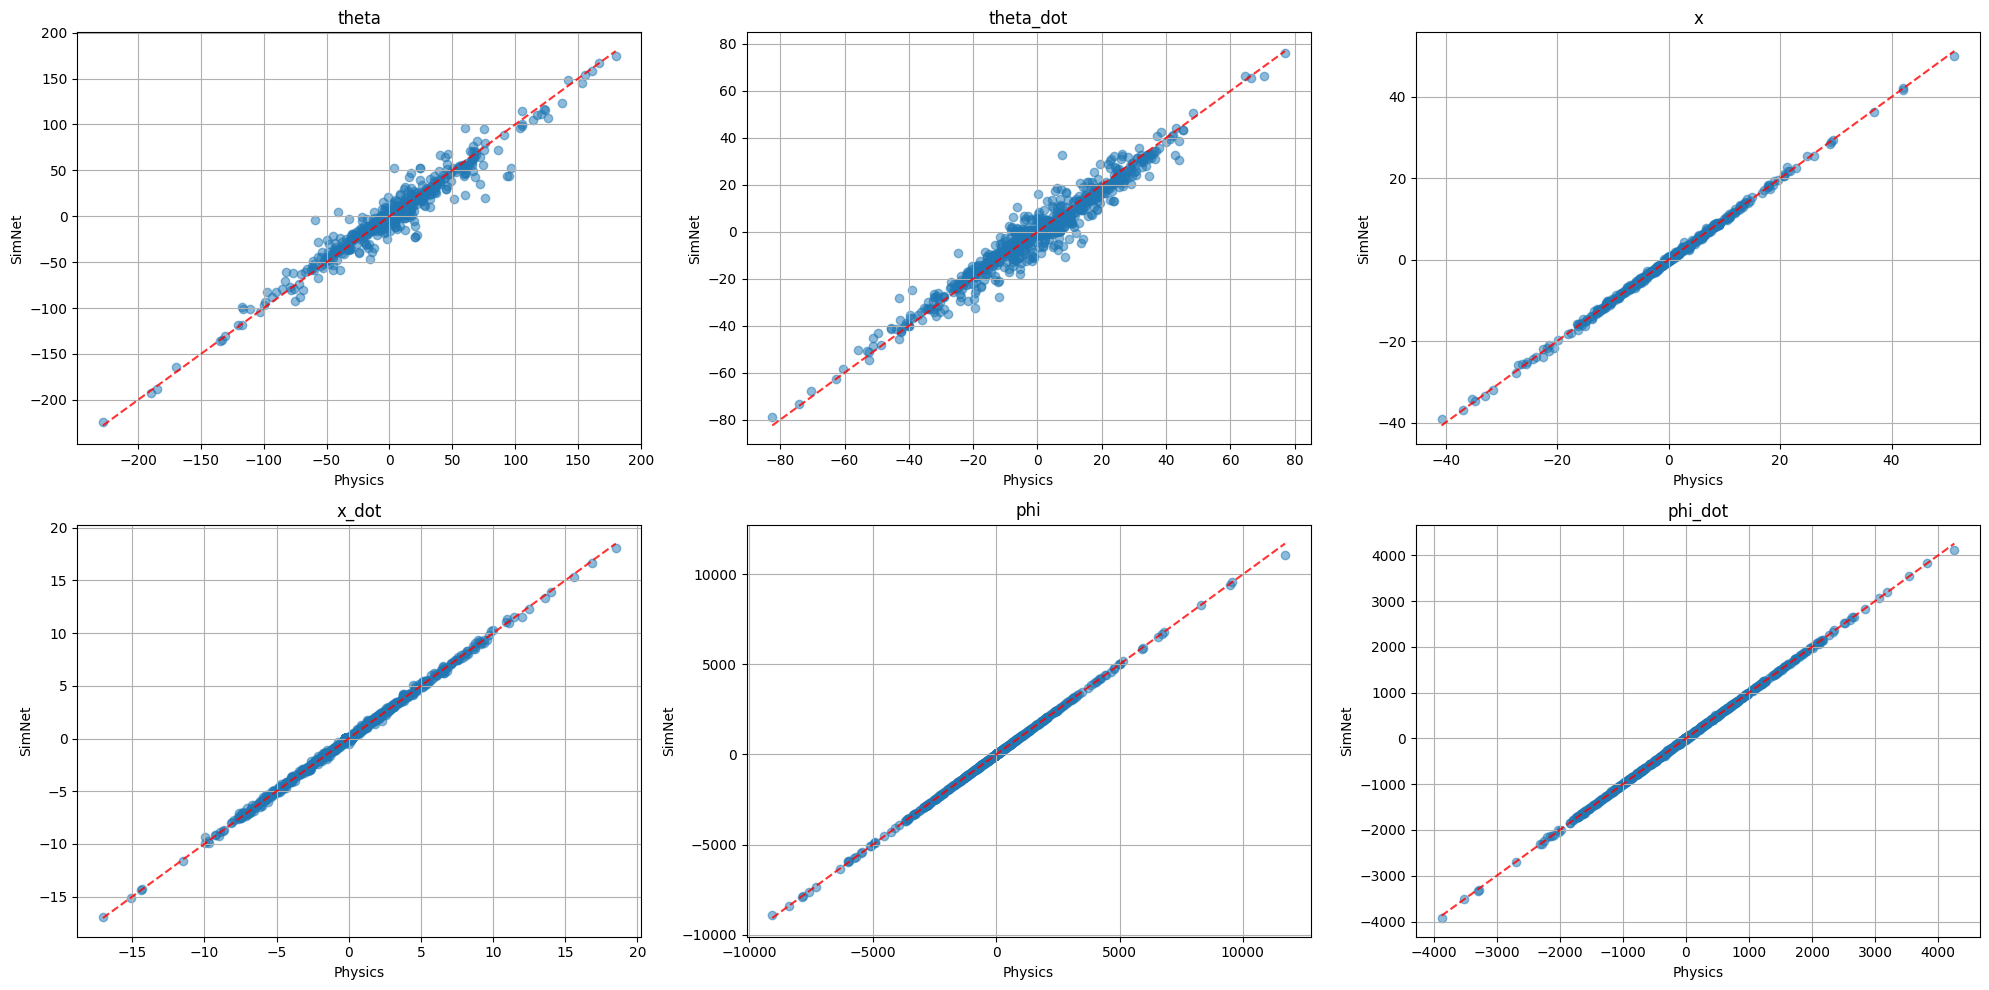

In [8]:

test_states = val_data["states"][:1000]
test_actions = val_data["actions"][:1000]
physics_preds = val_data["next_states"][:1000]  # The actual next states from the physics data

# Get SimNet predictions
simnet_preds = []
for s, a in zip(test_states, test_actions):
    s_tensor = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    a_tensor = torch.tensor(a, dtype=torch.float32).unsqueeze(0)
    pred_next = trainer.simnet(s_tensor, a_tensor).detach().numpy()[0]
    simnet_preds.append(pred_next)
simnet_preds = np.array(simnet_preds)

# Plot comparison (assuming your plot function looks something like this)
fig = plot_predictions_comparison(
    physics_preds=physics_preds,   # ground-truth next states
    simnet_preds=simnet_preds,     # network-predicted next states
    save_path=log_dir / "prediction_comparison.png"
)
plt.show()


## Save Final Model

In [9]:
# # Save trained SimNet
# torch.save({
#     'state_dict': trainer.simnet.state_dict(),
#     'physics_history': physics_history,
#     'real_history': real_history,
#     'config': simnet_config,
#     'metadata': {
#         'state_dim': env.observation_space.shape[0],
#         'action_dim': env.action_space.shape[0],
#         'hidden_dims': simnet_config['model']['hidden_dims']
#     }
# }, log_dir / 'simnet_final.pt')


# Save trained SimNet
torch.save({
    'state_dict': trainer.simnet.state_dict(),
    'physics_history': physics_history,
    'config': simnet_config,
    'metadata': {
        'state_dim': env.observation_space.shape[0],
        'action_dim': env.action_space.shape[0],
        'hidden_dims': simnet_config['model']['hidden_dims']
    }
}, log_dir / 'simnet_final.pt')